In [1]:
import datetime
from packaging import version
from collections import Counter
import numpy as np
import pandas as pd
import time
import os
import re
import string
import statistics
import random

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import nltk
from nltk.corpus import stopwords

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


from skimage.transform import resize
from skimage import data

# import tensorflow as tf
# from tensorflow import keras
# import tensorflow_datasets as tfds
# from tensorflow import keras
# from tensorflow.keras import layers
# import tensorflow.keras.backend as k


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.backend as k
# from tensorflow.keras.optimizers.legacy import Adam

from tensorflow.python.client import device_lib

In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [3]:
%matplotlib inline
np.set_printoptions(precision=3, suppress=True)

In [4]:
print("This notebook requires TensorFlow 2.0 or above")
print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >=2

This notebook requires TensorFlow 2.0 or above
TensorFlow version:  2.10.1


In [5]:
print("Keras version: ", keras.__version__)
device_lib.list_local_devices()


Keras version:  2.10.0


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 12871665964703776738
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 22385000448
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 4006549716496776587
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:01:00.0, compute capability: 8.9"
 xla_global_id: 416903419]

In [6]:
tf.test.is_built_with_cuda()

True

In [7]:
seed_val = 43

# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.
np.random.seed(seed_val)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.
random.seed(seed_val)

# The below set_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see:
# https://www.tensorflow.org/api_docs/python/tf/random/set_seed
tf.random.set_seed(seed_val)

In [8]:
def get_three_classes(x, y):
    def indices_of(class_id):
        indices, _ = np.where(y == float(class_id))
        return indices

    indices = np.concatenate([indices_of(0), indices_of(1), indices_of(2)], axis=0)
    
    x = x[indices]
    y = y[indices]
    
    count = x.shape[0]
    indices = np.random.choice(range(count), count, replace=False)
    
    x = x[indices]
    y = y[indices]
    
    y = tf.keras.utils.to_categorical(y)
    
    return x, y


def show_random_examples(x, y, p):
    indices = np.random.choice(range(x.shape[0]), 10, replace=False)
    
    x = x[indices]
    y = y[indices]
    p = p[indices]
    
    plt.figure(figsize=(10, 5))
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.imshow(x[i], cmap=plt.cm.binary)
        plt.xticks([])
        plt.yticks([])
        col = 'black' if np.argmax(y[i]) == np.argmax(p[i]) else 'red'
        plt.xlabel(class_names[np.argmax(p[i])], color=col)
    plt.show()


def plot_history(history):
    losses = history.history['loss']
    accs = history.history['accuracy']
    val_losses = history.history['val_loss']
    val_accs = history.history['val_accuracy']
    epochs = len(losses)

    plt.figure(figsize=(16, 4))
    for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
        plt.subplot(1, 2, i + 1)
        plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
        plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
        plt.legend()
    plt.show()

def display_training_curves(training, validation, title, subplot):
    ax = plt.subplot(subplot)
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    ax.set_xlabel('epoch')
    ax.legend(['training', 'validation'])

def print_validation_report(y_test, predictions):
    print("Classification Report")
    print(classification_report(y_test, predictions))
    print('Accuracy Score: {}'.format(accuracy_score(y_test, predictions)))
    print('Root Mean Square Error: {}'.format(np.sqrt(MSE(y_test, predictions)))) 
    
def plot_confusion_matrix(y_true, y_pred):
    class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
    mtx = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(16,12))
#    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white', 
                xticklabels=class_names, yticklabels=class_names)
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')

In [9]:
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()
assert x_train.shape == (60000, 28, 28)
assert x_test.shape == (10000, 28, 28)
assert y_train.shape == (60000,)
assert y_test.shape == (10000,)

In [10]:
print("x_train shape:", x_train.shape, "y_train shape:", y_train.shape)

x_train shape: (60000, 28, 28) y_train shape: (60000,)


In [11]:
y_train = y_train.reshape([y_train.shape[0], 1])
y_test = y_test.reshape([y_test.shape[0], 1])

In [12]:
print("First ten labels training dataset:\n {}\n".format(y_train[0:10]))
print("This output the numeric label, need to convert to item description")

First ten labels training dataset:
 [[9]
 [0]
 [0]
 [3]
 [0]
 [2]
 [7]
 [2]
 [5]
 [5]]

This output the numeric label, need to convert to item description


In [13]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [14]:
(train_images, train_labels),(test_images, test_labels)= tf.keras.datasets.fashion_mnist.load_data()

In [15]:
train_labels = train_labels.reshape([train_labels.shape[0], 1])
test_labels = test_labels.reshape([test_labels.shape[0], 1])

In [16]:
x_preview, y_preview = get_three_classes(train_images, train_labels)
x_preview, y_preview = get_three_classes(test_images, test_labels)

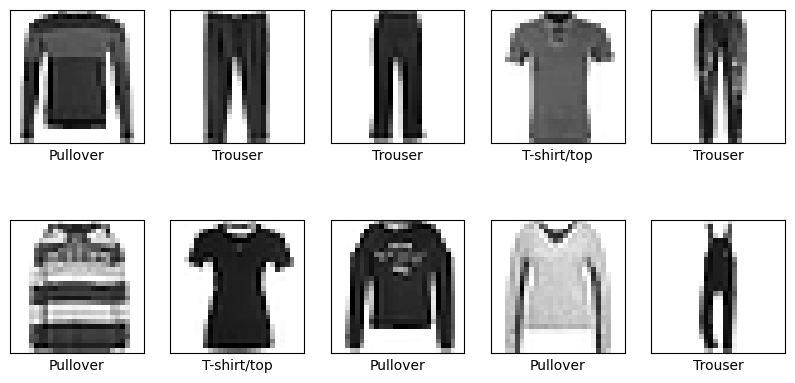

In [17]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
show_random_examples(x_preview, y_preview, y_preview)

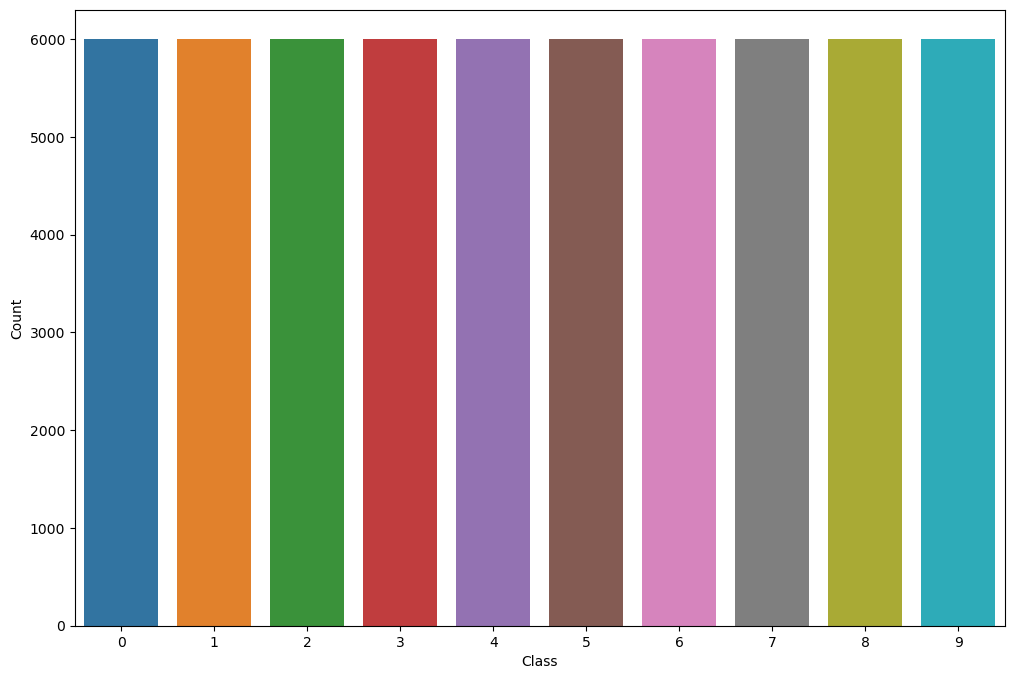

In [18]:
plt.figure(figsize = (12 ,8))
items = [{'Class': x, 'Count': y} for x, y in Counter(train_labels.ravel()).items()]
distribution = pd.DataFrame(items).sort_values(['Class'])
sns.barplot(x=distribution.Class, y=distribution.Count);

## Create Validation Data Set

In [19]:
x_train, x_valid, y_train, y_valid = train_test_split(x_train
                                                      ,y_train
                                                      ,test_size=.1
                                                      ,random_state=seed_val
                                                      ,shuffle=True)

## Confirm Datasets {Train, Validation, Test}

In [20]:
print(x_train.shape, x_valid.shape, x_test.shape)

(54000, 28, 28) (6000, 28, 28) (10000, 28, 28)


## Rescale Examples  {Train, Validation, Test}
The images are 28x28 NumPy arrays, with pixel values ranging from 0 to 255

1. Each element in each example is a pixel value
2. Pixel values range from 0 to 255
3. 0 = black
4. 255 = white

In [21]:
x_train = x_train/255
x_valid = x_valid/255
x_test = x_test/255

# Data Transformation for Pre-Trained models
# ----------------------------------------

In [22]:
def resize_all(x, shape = (48,48)):
    band_shape = x.shape
    x_resize = np.zeros(shape = (band_shape[0],shape[0],shape[1]))
    for i in range(band_shape[0]):
        x_resize[i] = resize(x[i], shape)
    return x_resize

def transform_input_vgg(x):
    x_vgg = np.array(x).reshape(-1,28,28)
    x_vgg = resize_all(x_vgg, (48,48))
    x_vgg = np.repeat(x_vgg[:, :, :, np.newaxis], 3, axis=3)
    return x_vgg

def transform_input(x, size=48):
    x_vgg = np.array(x).reshape(-1,28,28)
    x_vgg = resize_all(x_vgg, (size,size))
    x_vgg = np.repeat(x_vgg[:, :, :, np.newaxis], 3, axis=3)
    return x_vgg

In [23]:
x_train_tf = transform_input_vgg(x_train)
x_valid_tf = transform_input_vgg(x_valid)
x_test_tf = transform_input_vgg(x_test)

In [24]:
x_train_tf_inception = transform_input(x_train, 75)
x_valid_tf_inception = transform_input(x_valid, 75)
x_test_tf_inception = transform_input(x_test, 75)

In [43]:
x_train_tf_resnet = transform_input(x_train, 32)
x_valid_tf_resnet = transform_input(x_valid, 32)
x_test_tf_resnet = transform_input(x_test, 32)

# Pre-Trained models
# ----------------------------------------

In [24]:
# vgg_16 = keras.applications.vgg16.VGG16(weights= None , include_top=False, 
#                      input_shape=(48, 48, 3))
# vgg_16.load_weights('vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5')
# vgg_16.trainable = False

In [24]:
vgg_16 = keras.applications.vgg16.VGG16(weights='imagenet', include_top=False, 
                     input_shape=(48, 48, 3))
vgg_16.trainable = False

In [25]:
vgg_16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

In [38]:
vgg_19 = keras.applications.vgg19.VGG19(weights='imagenet', include_top=False, 
                     input_shape=(48, 48, 3))
vgg_19.trainable = False

In [39]:
vgg_19.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

In [25]:
inception_v3 = keras.applications.InceptionV3(weights='imagenet', include_top=False, 
                     input_shape=(75, 75, 3))
inception_v3.trainable = False

In [26]:
inception_v3.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 75, 75, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 37, 37, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 37, 37, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 37, 37, 32)   0           ['batch_normalization[

 ormalization)                                                                                    
                                                                                                  
 batch_normalization_11 (BatchN  (None, 7, 7, 32)    96          ['conv2d_11[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_5 (Activation)      (None, 7, 7, 64)     0           ['batch_normalization_5[0][0]']  
                                                                                                  
 activation_7 (Activation)      (None, 7, 7, 64)     0           ['batch_normalization_7[0][0]']  
                                                                                                  
 activation_10 (Activation)     (None, 7, 7, 96)     0           ['batch_normalization_10[0][0]'] 
          

                                                                                                  
 conv2d_23 (Conv2D)             (None, 7, 7, 96)     55296       ['activation_22[0][0]']          
                                                                                                  
 batch_normalization_20 (BatchN  (None, 7, 7, 48)    144         ['conv2d_20[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_23 (BatchN  (None, 7, 7, 96)    288         ['conv2d_23[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_20 (Activation)     (None, 7, 7, 48)     0           ['batch_normalization_20[0][0]'] 
          

 conv2d_34 (Conv2D)             (None, 3, 3, 128)    98304       ['mixed3[0][0]']                 
                                                                                                  
 batch_normalization_34 (BatchN  (None, 3, 3, 128)   384         ['conv2d_34[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_34 (Activation)     (None, 3, 3, 128)    0           ['batch_normalization_34[0][0]'] 
                                                                                                  
 conv2d_35 (Conv2D)             (None, 3, 3, 128)    114688      ['activation_34[0][0]']          
                                                                                                  
 batch_normalization_35 (BatchN  (None, 3, 3, 128)   384         ['conv2d_35[0][0]']              
 ormalizat

 activation_44 (Activation)     (None, 3, 3, 160)    0           ['batch_normalization_44[0][0]'] 
                                                                                                  
 conv2d_45 (Conv2D)             (None, 3, 3, 160)    179200      ['activation_44[0][0]']          
                                                                                                  
 batch_normalization_45 (BatchN  (None, 3, 3, 160)   480         ['conv2d_45[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_45 (Activation)     (None, 3, 3, 160)    0           ['batch_normalization_45[0][0]'] 
                                                                                                  
 conv2d_41 (Conv2D)             (None, 3, 3, 160)    122880      ['mixed4[0][0]']                 
          

 ormalization)                                                                                    
                                                                                                  
 activation_55 (Activation)     (None, 3, 3, 160)    0           ['batch_normalization_55[0][0]'] 
                                                                                                  
 conv2d_51 (Conv2D)             (None, 3, 3, 160)    122880      ['mixed5[0][0]']                 
                                                                                                  
 conv2d_56 (Conv2D)             (None, 3, 3, 160)    179200      ['activation_55[0][0]']          
                                                                                                  
 batch_normalization_51 (BatchN  (None, 3, 3, 160)   480         ['conv2d_51[0][0]']              
 ormalization)                                                                                    
          

                                                                                                  
 conv2d_66 (Conv2D)             (None, 3, 3, 192)    258048      ['activation_65[0][0]']          
                                                                                                  
 batch_normalization_61 (BatchN  (None, 3, 3, 192)   576         ['conv2d_61[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_66 (BatchN  (None, 3, 3, 192)   576         ['conv2d_66[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_61 (Activation)     (None, 3, 3, 192)    0           ['batch_normalization_61[0][0]'] 
          

                                                                                                  
 batch_normalization_74 (BatchN  (None, 3, 3, 192)   576         ['conv2d_74[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_70 (Activation)     (None, 3, 3, 192)    0           ['batch_normalization_70[0][0]'] 
                                                                                                  
 activation_74 (Activation)     (None, 3, 3, 192)    0           ['batch_normalization_74[0][0]'] 
                                                                                                  
 conv2d_71 (Conv2D)             (None, 1, 1, 320)    552960      ['activation_70[0][0]']          
                                                                                                  
 conv2d_75

 activation_82 (Activation)     (None, 1, 1, 384)    0           ['batch_normalization_82[0][0]'] 
                                                                                                  
 activation_83 (Activation)     (None, 1, 1, 384)    0           ['batch_normalization_83[0][0]'] 
                                                                                                  
 batch_normalization_84 (BatchN  (None, 1, 1, 192)   576         ['conv2d_84[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_76 (Activation)     (None, 1, 1, 320)    0           ['batch_normalization_76[0][0]'] 
                                                                                                  
 mixed9_0 (Concatenate)         (None, 1, 1, 768)    0           ['activation_78[0][0]',          
          

                                                                                                  
 activation_85 (Activation)     (None, 1, 1, 320)    0           ['batch_normalization_85[0][0]'] 
                                                                                                  
 mixed9_1 (Concatenate)         (None, 1, 1, 768)    0           ['activation_87[0][0]',          
                                                                  'activation_88[0][0]']          
                                                                                                  
 concatenate_1 (Concatenate)    (None, 1, 1, 768)    0           ['activation_91[0][0]',          
                                                                  'activation_92[0][0]']          
                                                                                                  
 activation_93 (Activation)     (None, 1, 1, 192)    0           ['batch_normalization_93[0][0]'] 
          

In [48]:
resnet152_V2 = keras.applications.ResNet152V2(weights='imagenet', include_top=False, 
                     input_shape=(32, 32, 3))
resnet152_V2.trainable = False

In [49]:
resnet152_V2.summary()

Model: "resnet152v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 38, 38, 3)    0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 16, 16, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 pool1_pad (ZeroPadding2D)      (None, 18, 18, 64)   0           ['conv1_conv[0][0]']             
                                                                                        

                                                                                                  
 conv2_block3_1_conv (Conv2D)   (None, 8, 8, 64)     16384       ['conv2_block3_preact_relu[0][0]'
                                                                 ]                                
                                                                                                  
 conv2_block3_1_bn (BatchNormal  (None, 8, 8, 64)    256         ['conv2_block3_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 8, 8, 64)    0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_blo

 ization)                                                                                         
                                                                                                  
 conv3_block2_2_relu (Activatio  (None, 4, 4, 128)   0           ['conv3_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block2_3_conv (Conv2D)   (None, 4, 4, 512)    66048       ['conv3_block2_2_relu[0][0]']    
                                                                                                  
 conv3_block2_out (Add)         (None, 4, 4, 512)    0           ['conv3_block1_out[0][0]',       
                                                                  'conv3_block2_3_conv[0][0]']    
                                                                                                  
 conv3_blo

                                                                                                  
 conv3_block5_1_relu (Activatio  (None, 4, 4, 128)   0           ['conv3_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block5_2_pad (ZeroPaddin  (None, 6, 6, 128)   0           ['conv3_block5_1_relu[0][0]']    
 g2D)                                                                                             
                                                                                                  
 conv3_block5_2_conv (Conv2D)   (None, 4, 4, 128)    147456      ['conv3_block5_2_pad[0][0]']     
                                                                                                  
 conv3_block5_2_bn (BatchNormal  (None, 4, 4, 128)   512         ['conv3_block5_2_conv[0][0]']    
 ization) 

 ormalization)                                                                                    
                                                                                                  
 conv3_block8_preact_relu (Acti  (None, 4, 4, 512)   0           ['conv3_block8_preact_bn[0][0]'] 
 vation)                                                                                          
                                                                                                  
 conv3_block8_1_conv (Conv2D)   (None, 4, 4, 128)    65536       ['conv3_block8_preact_relu[0][0]'
                                                                 ]                                
                                                                                                  
 conv3_block8_1_bn (BatchNormal  (None, 4, 4, 128)   512         ['conv3_block8_1_conv[0][0]']    
 ization)                                                                                         
          

                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 2, 2, 256)    589824      ['conv4_block2_2_pad[0][0]']     
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 2, 2, 256)   1024        ['conv4_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_2_relu (Activatio  (None, 2, 2, 256)   0           ['conv4_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_3_conv (Conv2D)   (None, 2, 2, 1024)   263168      ['conv4_block2_2_relu[0][0]']    
          

                                                                 ]                                
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 2, 2, 256)   1024        ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 2, 2, 256)   0           ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_pad (ZeroPaddin  (None, 4, 4, 256)   0           ['conv4_block5_1_relu[0][0]']    
 g2D)                                                                                             
          

 conv4_block7_out (Add)         (None, 2, 2, 1024)   0           ['conv4_block6_out[0][0]',       
                                                                  'conv4_block7_3_conv[0][0]']    
                                                                                                  
 conv4_block8_preact_bn (BatchN  (None, 2, 2, 1024)  4096        ['conv4_block7_out[0][0]']       
 ormalization)                                                                                    
                                                                                                  
 conv4_block8_preact_relu (Acti  (None, 2, 2, 1024)  0           ['conv4_block8_preact_bn[0][0]'] 
 vation)                                                                                          
                                                                                                  
 conv4_block8_1_conv (Conv2D)   (None, 2, 2, 256)    262144      ['conv4_block8_preact_relu[0][0]'
          

 conv4_block10_2_conv (Conv2D)  (None, 2, 2, 256)    589824      ['conv4_block10_2_pad[0][0]']    
                                                                                                  
 conv4_block10_2_bn (BatchNorma  (None, 2, 2, 256)   1024        ['conv4_block10_2_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block10_2_relu (Activati  (None, 2, 2, 256)   0           ['conv4_block10_2_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block10_3_conv (Conv2D)  (None, 2, 2, 1024)   263168      ['conv4_block10_2_relu[0][0]']   
                                                                                                  
 conv4_blo

                                                                                                  
 conv4_block13_1_bn (BatchNorma  (None, 2, 2, 256)   1024        ['conv4_block13_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block13_1_relu (Activati  (None, 2, 2, 256)   0           ['conv4_block13_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block13_2_pad (ZeroPaddi  (None, 4, 4, 256)   0           ['conv4_block13_1_relu[0][0]']   
 ng2D)                                                                                            
                                                                                                  
 conv4_blo

                                                                  'conv4_block15_3_conv[0][0]']   
                                                                                                  
 conv4_block16_preact_bn (Batch  (None, 2, 2, 1024)  4096        ['conv4_block15_out[0][0]']      
 Normalization)                                                                                   
                                                                                                  
 conv4_block16_preact_relu (Act  (None, 2, 2, 1024)  0           ['conv4_block16_preact_bn[0][0]']
 ivation)                                                                                         
                                                                                                  
 conv4_block16_1_conv (Conv2D)  (None, 2, 2, 256)    262144      ['conv4_block16_preact_relu[0][0]
                                                                 ']                               
          

                                                                                                  
 conv4_block18_2_bn (BatchNorma  (None, 2, 2, 256)   1024        ['conv4_block18_2_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block18_2_relu (Activati  (None, 2, 2, 256)   0           ['conv4_block18_2_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block18_3_conv (Conv2D)  (None, 2, 2, 1024)   263168      ['conv4_block18_2_relu[0][0]']   
                                                                                                  
 conv4_block18_out (Add)        (None, 2, 2, 1024)   0           ['conv4_block17_out[0][0]',      
          

 conv4_block21_1_bn (BatchNorma  (None, 2, 2, 256)   1024        ['conv4_block21_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block21_1_relu (Activati  (None, 2, 2, 256)   0           ['conv4_block21_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block21_2_pad (ZeroPaddi  (None, 4, 4, 256)   0           ['conv4_block21_1_relu[0][0]']   
 ng2D)                                                                                            
                                                                                                  
 conv4_block21_2_conv (Conv2D)  (None, 2, 2, 256)    589824      ['conv4_block21_2_pad[0][0]']    
          

                                                                                                  
 conv4_block24_preact_bn (Batch  (None, 2, 2, 1024)  4096        ['conv4_block23_out[0][0]']      
 Normalization)                                                                                   
                                                                                                  
 conv4_block24_preact_relu (Act  (None, 2, 2, 1024)  0           ['conv4_block24_preact_bn[0][0]']
 ivation)                                                                                         
                                                                                                  
 conv4_block24_1_conv (Conv2D)  (None, 2, 2, 256)    262144      ['conv4_block24_preact_relu[0][0]
                                                                 ']                               
                                                                                                  
 conv4_blo

 conv4_block26_2_bn (BatchNorma  (None, 2, 2, 256)   1024        ['conv4_block26_2_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block26_2_relu (Activati  (None, 2, 2, 256)   0           ['conv4_block26_2_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block26_3_conv (Conv2D)  (None, 2, 2, 1024)   263168      ['conv4_block26_2_relu[0][0]']   
                                                                                                  
 conv4_block26_out (Add)        (None, 2, 2, 1024)   0           ['conv4_block25_out[0][0]',      
                                                                  'conv4_block26_3_conv[0][0]']   
          

 lization)                                                                                        
                                                                                                  
 conv4_block29_1_relu (Activati  (None, 2, 2, 256)   0           ['conv4_block29_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block29_2_pad (ZeroPaddi  (None, 4, 4, 256)   0           ['conv4_block29_1_relu[0][0]']   
 ng2D)                                                                                            
                                                                                                  
 conv4_block29_2_conv (Conv2D)  (None, 2, 2, 256)    589824      ['conv4_block29_2_pad[0][0]']    
                                                                                                  
 conv4_blo

 conv4_block32_preact_bn (Batch  (None, 2, 2, 1024)  4096        ['conv4_block31_out[0][0]']      
 Normalization)                                                                                   
                                                                                                  
 conv4_block32_preact_relu (Act  (None, 2, 2, 1024)  0           ['conv4_block32_preact_bn[0][0]']
 ivation)                                                                                         
                                                                                                  
 conv4_block32_1_conv (Conv2D)  (None, 2, 2, 256)    262144      ['conv4_block32_preact_relu[0][0]
                                                                 ']                               
                                                                                                  
 conv4_block32_1_bn (BatchNorma  (None, 2, 2, 256)   1024        ['conv4_block32_1_conv[0][0]']   
 lization)

 lization)                                                                                        
                                                                                                  
 conv4_block34_2_relu (Activati  (None, 2, 2, 256)   0           ['conv4_block34_2_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block34_3_conv (Conv2D)  (None, 2, 2, 1024)   263168      ['conv4_block34_2_relu[0][0]']   
                                                                                                  
 conv4_block34_out (Add)        (None, 2, 2, 1024)   0           ['conv4_block33_out[0][0]',      
                                                                  'conv4_block34_3_conv[0][0]']   
                                                                                                  
 conv4_blo

 conv5_block1_1_bn (BatchNormal  (None, 1, 1, 512)   2048        ['conv5_block1_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block1_1_relu (Activatio  (None, 1, 1, 512)   0           ['conv5_block1_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block1_2_pad (ZeroPaddin  (None, 3, 3, 512)   0           ['conv5_block1_1_relu[0][0]']    
 g2D)                                                                                             
                                                                                                  
 conv5_block1_2_conv (Conv2D)   (None, 1, 1, 512)    2359296     ['conv5_block1_2_pad[0][0]']     
          

                                                                                                  
 conv5_block3_out (Add)         (None, 1, 1, 2048)   0           ['conv5_block2_out[0][0]',       
                                                                  'conv5_block3_3_conv[0][0]']    
                                                                                                  
 post_bn (BatchNormalization)   (None, 1, 1, 2048)   8192        ['conv5_block3_out[0][0]']       
                                                                                                  
 post_relu (Activation)         (None, 1, 1, 2048)   0           ['post_bn[0][0]']                
                                                                                                  
Total params: 58,331,648
Trainable params: 0
Non-trainable params: 58,331,648
__________________________________________________________________________________________________


# STOP INITIALIZATION HERE
# ----------------------------------------
# ----------------------------------------
# ----------------------------------------
# ----------------------------------------

## Experiment 1

- VGG16
- DNN with 2 layers (384, 768)
- no regularization

In [26]:
k.clear_session()
model_01 = Sequential([
   vgg_16,
#   vgg_19,
   Flatten(),
   Dense(units=384,activation=tf.nn.relu),
#   Dense(units=384,activation=tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
#   BatchNormalization(),
#   Dropout(0.2),
   Dense(units=768,activation=tf.nn.relu),
#   Dense(units=768,activation=tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
#   BatchNormalization(),
#   Dropout(0.2),
   Dense(units=10, activation=tf.nn.softmax)       
])

In [27]:
model_01.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 384)               196992    
                                                                 
 dense_1 (Dense)             (None, 768)               295680    
                                                                 
 dense_2 (Dense)             (None, 10)                7690      
                                                                 
Total params: 15,215,050
Trainable params: 500,362
Non-trainable params: 14,714,688
_________________________________________________________________


In [28]:
keras.utils.plot_model(model_01, "FASHION-MNIST_PT_EXP-01.png", show_shapes=True) 

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [29]:
model_01.compile(optimizer='adam',
               loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])

In [30]:
history_01 = model_01.fit(x_train_tf
                    ,y_train
                    ,epochs=200
                    ,batch_size=64
                    ,verbose=1
                    ,validation_data=(x_valid_tf, y_valid)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("FASHION-MNIST_PT_EXP-01.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5),
                    ]                                                                                                           
                   )

Epoch 1/200
844/844 [==============================] - 21s 5ms/step - loss: 0.4758 - accuracy: 0.8258 - val_loss: 0.4116 - val_accuracy: 0.8425
Epoch 2/200
844/844 [==============================] - 4s 5ms/step - loss: 0.3550 - accuracy: 0.8684 - val_loss: 0.3416 - val_accuracy: 0.8735
Epoch 3/200
844/844 [==============================] - 4s 5ms/step - loss: 0.3212 - accuracy: 0.8803 - val_loss: 0.3239 - val_accuracy: 0.8802
Epoch 4/200
844/844 [==============================] - 4s 5ms/step - loss: 0.2959 - accuracy: 0.8886 - val_loss: 0.3146 - val_accuracy: 0.8865
Epoch 5/200
844/844 [==============================] - 4s 5ms/step - loss: 0.2742 - accuracy: 0.8970 - val_loss: 0.3200 - val_accuracy: 0.8792
Epoch 6/200
844/844 [==============================] - 4s 5ms/step - loss: 0.2605 - accuracy: 0.9015 - val_loss: 0.2952 - val_accuracy: 0.8907
Epoch 7/200
844/844 [==============================] - 4s 5ms/step - loss: 0.2407 - accuracy: 0.9079 - val_loss: 0.3119 - val_accuracy: 0.885

In [31]:
model_01 = tf.keras.models.load_model("FASHION-MNIST_PT_EXP-01.h5") # VGG16, no regularization
print(f"Test acc: {model_01.evaluate(x_test_tf, y_test)[1]:.3f}")

313/313 [==============================] - 1s 3ms/step - loss: 0.3322 - accuracy: 0.8828
Test acc: 0.883


C:\Users\reedb\AppData\Local\Temp\ipykernel_2136\723324890.py:56: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(subplot)


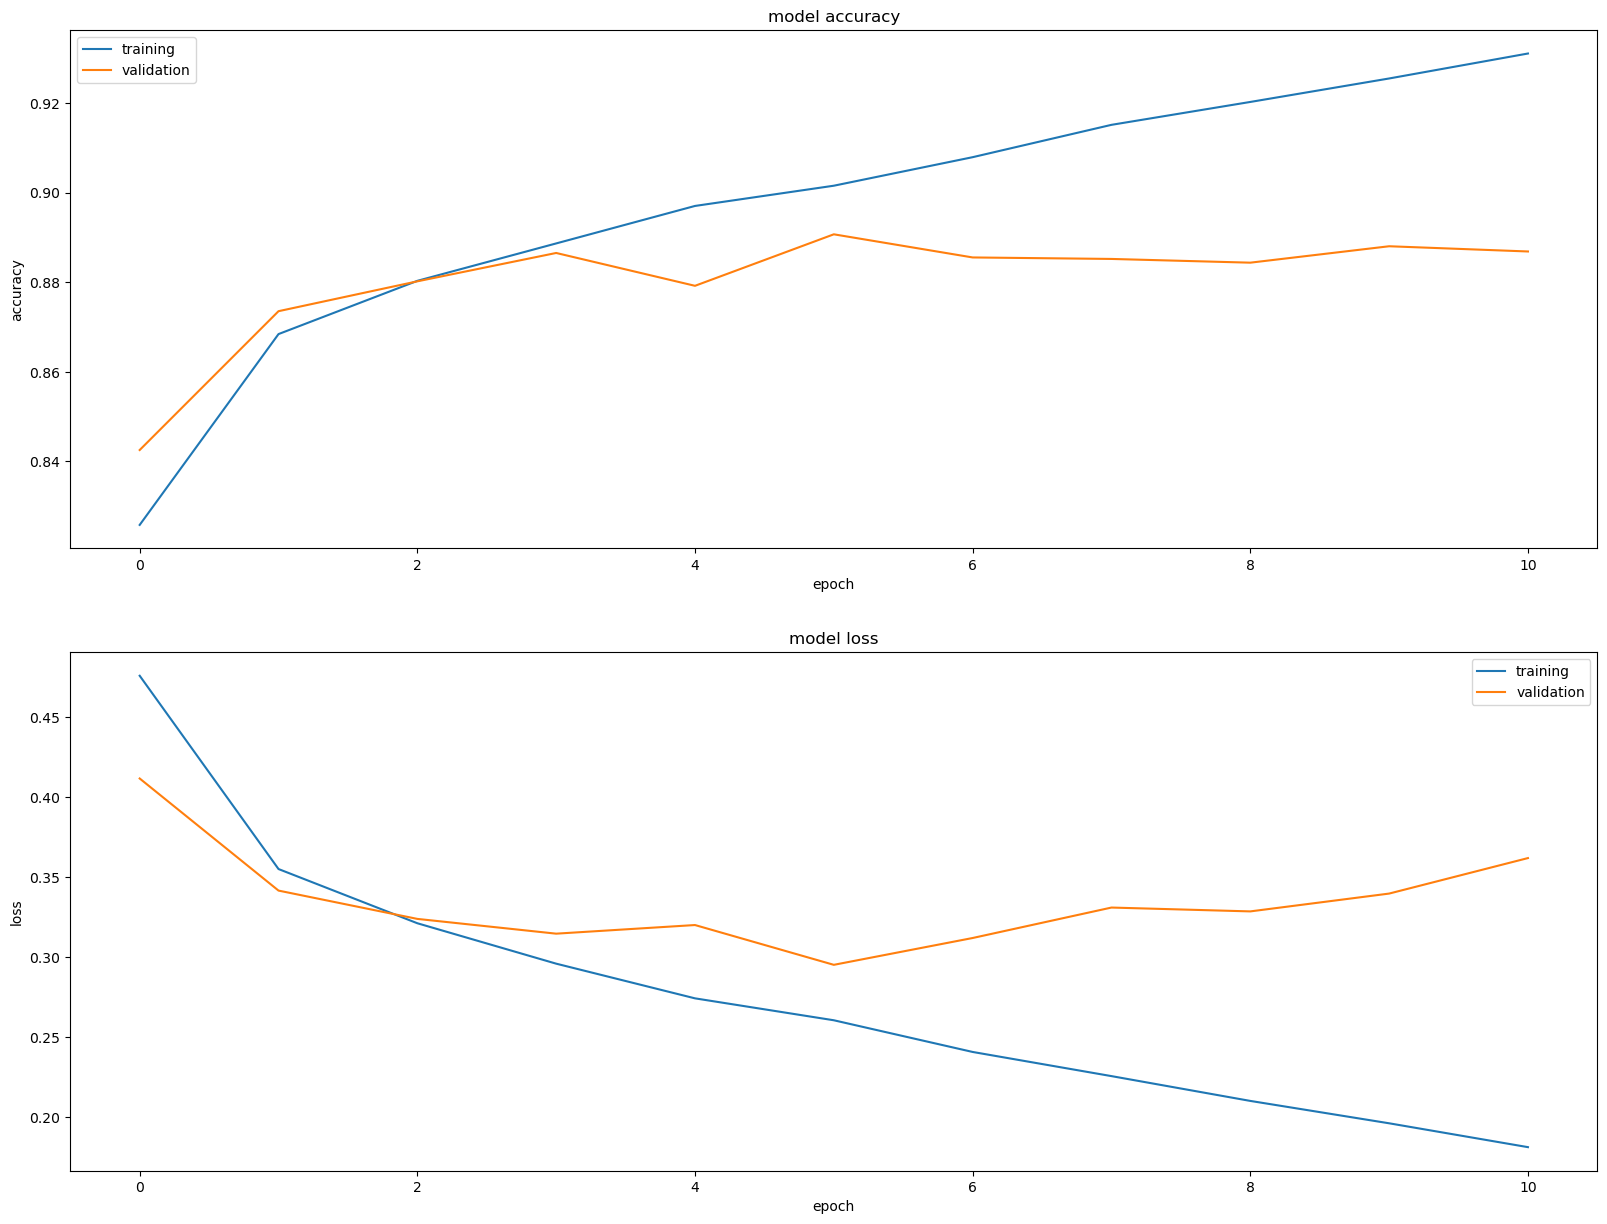

In [32]:
plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history_01.history['accuracy'], history_01.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history_01.history['loss'], history_01.history['val_loss'], 'loss', 212)

In [33]:
history_01_dict = history_01.history
history_01_df=pd.DataFrame(history_01_dict)
history_01_df.tail().round(3)

,loss,accuracy,val_loss,val_accuracy
6,0.241,0.908,0.312,0.886
7,0.226,0.915,0.331,0.885
8,0.210,0.920,0.329,0.884
9,0.196,0.925,0.340,0.888
10,0.181,0.931,0.362,0.887


In [34]:
pred_01 = model_01.predict(x_test_tf)
pred_01_cm=np.argmax(pred_01, axis=1)
print_validation_report(y_test, pred_01_cm)

313/313 [==============================] - 1s 2ms/step
Classification Report
              precision    recall  f1-score   support

           0       0.83      0.85      0.84      1000
           1       0.98      0.98      0.98      1000
           2       0.85      0.80      0.82      1000
           3       0.86      0.89      0.87      1000
           4       0.78      0.82      0.80      1000
           5       0.97      0.95      0.96      1000
           6       0.72      0.66      0.68      1000
           7       0.93      0.94      0.94      1000
           8       0.96      0.98      0.97      1000
           9       0.95      0.96      0.95      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000

Accuracy Score: 0.8828
Root Mean Square Error: 1.2357993364620325


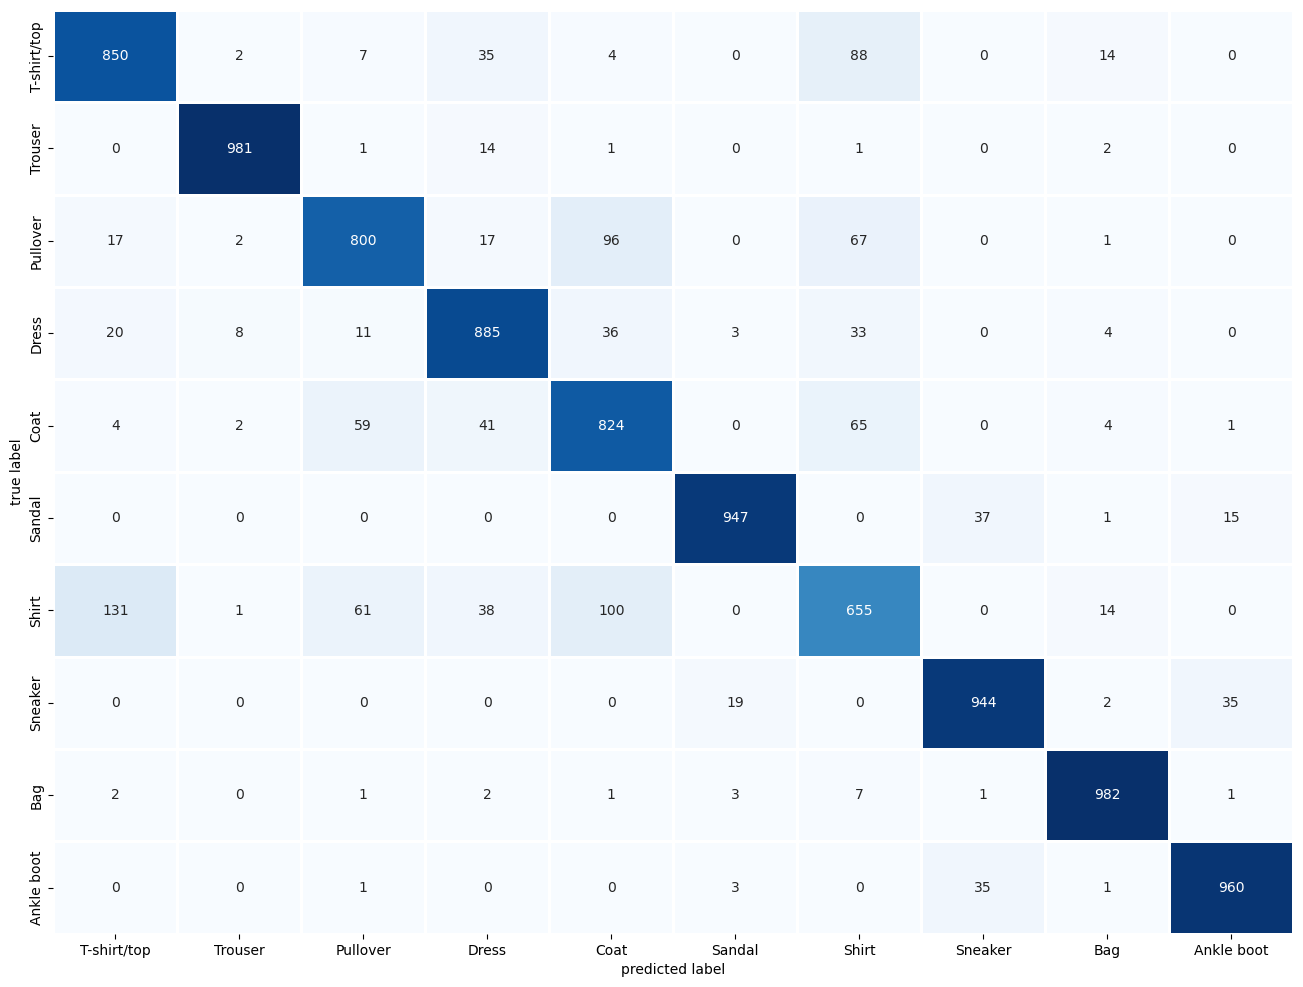

In [35]:
plot_confusion_matrix(y_test,pred_01_cm)

In [36]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)
df = pd.DataFrame(pred_01[0:20], columns = class_names)
df.style.format("{:.2%}").background_gradient(cmap=cm)

,T-shirt/top,Trouser,Pullover,Dress,Coat,Sandal,Shirt,Sneaker,Bag,Ankle boot
0,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.01%,0.00%,99.99%
1,0.01%,0.00%,99.71%,0.00%,0.01%,0.00%,0.28%,0.00%,0.00%,0.00%
2,0.00%,100.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
3,0.00%,100.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
4,44.24%,0.00%,1.46%,0.09%,0.32%,0.04%,53.70%,0.03%,0.08%,0.04%
5,0.00%,100.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
6,2.82%,0.03%,37.08%,1.87%,24.28%,0.00%,33.92%,0.00%,0.00%,0.00%
7,0.14%,0.00%,0.84%,0.17%,2.91%,0.00%,95.93%,0.00%,0.01%,0.00%
8,0.02%,0.00%,0.00%,0.05%,0.00%,99.24%,0.01%,0.47%,0.14%,0.07%
9,0.00%,0.00%,0.00%,0.00%,0.00%,0.33%,0.00%,99.66%,0.00%,0.01%


## Experiment 2

- VGG19
- DNN with 2 layers (384, 768)
- no regularization

In [40]:
k.clear_session()
model_02 = Sequential([
#   vgg_16,
   vgg_19,
   Flatten(),
   Dense(units=384,activation=tf.nn.relu),
#   Dense(units=384,activation=tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
#   BatchNormalization(),
#   Dropout(0.2),
   Dense(units=768,activation=tf.nn.relu),
#   Dense(units=768,activation=tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
#   BatchNormalization(),
#   Dropout(0.2),
   Dense(units=10, activation=tf.nn.softmax)       
])

In [41]:
model_02.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 1, 1, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 384)               196992    
                                                                 
 dense_1 (Dense)             (None, 768)               295680    
                                                                 
 dense_2 (Dense)             (None, 10)                7690      
                                                                 
Total params: 20,524,746
Trainable params: 500,362
Non-trainable params: 20,024,384
_________________________________________________________________


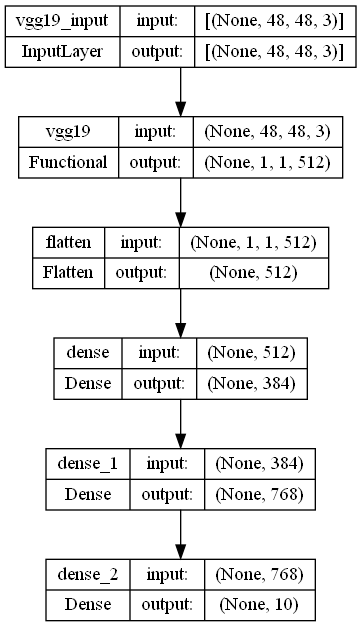

In [42]:
keras.utils.plot_model(model_02, "FASHION-MNIST_PT_EXP-02.png", show_shapes=True) 

In [43]:
model_02.compile(optimizer='adam',
               loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])

In [44]:
history_02 = model_02.fit(x_train_tf
                    ,y_train
                    ,epochs=200
                    ,batch_size=64
                    ,verbose=1
                    ,validation_data=(x_valid_tf, y_valid)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("FASHION-MNIST_PT_EXP-02.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5),
                    ]                                                                                                           
                   )

Epoch 1/200
844/844 [==============================] - 16s 18ms/step - loss: 0.4993 - accuracy: 0.8185 - val_loss: 0.4229 - val_accuracy: 0.8415
Epoch 2/200
844/844 [==============================] - 15s 18ms/step - loss: 0.3761 - accuracy: 0.8612 - val_loss: 0.3731 - val_accuracy: 0.8667
Epoch 3/200
844/844 [==============================] - 15s 18ms/step - loss: 0.3418 - accuracy: 0.8735 - val_loss: 0.3548 - val_accuracy: 0.8700
Epoch 4/200
844/844 [==============================] - 15s 17ms/step - loss: 0.3188 - accuracy: 0.8819 - val_loss: 0.3472 - val_accuracy: 0.8725
Epoch 5/200
844/844 [==============================] - 16s 18ms/step - loss: 0.3006 - accuracy: 0.8877 - val_loss: 0.3421 - val_accuracy: 0.8807
Epoch 6/200
844/844 [==============================] - 15s 18ms/step - loss: 0.2867 - accuracy: 0.8913 - val_loss: 0.3332 - val_accuracy: 0.8827
Epoch 7/200
844/844 [==============================] - 15s 17ms/step - loss: 0.2702 - accuracy: 0.8992 - val_loss: 0.3240 - val_ac

In [45]:
model_02 = tf.keras.models.load_model("FASHION-MNIST_PT_EXP-02.h5") # VGG19, no regularization
print(f"Test acc: {model_02.evaluate(x_test_tf, y_test)[1]:.3f}")

313/313 [==============================] - 3s 10ms/step - loss: 0.3533 - accuracy: 0.8734
Test acc: 0.873


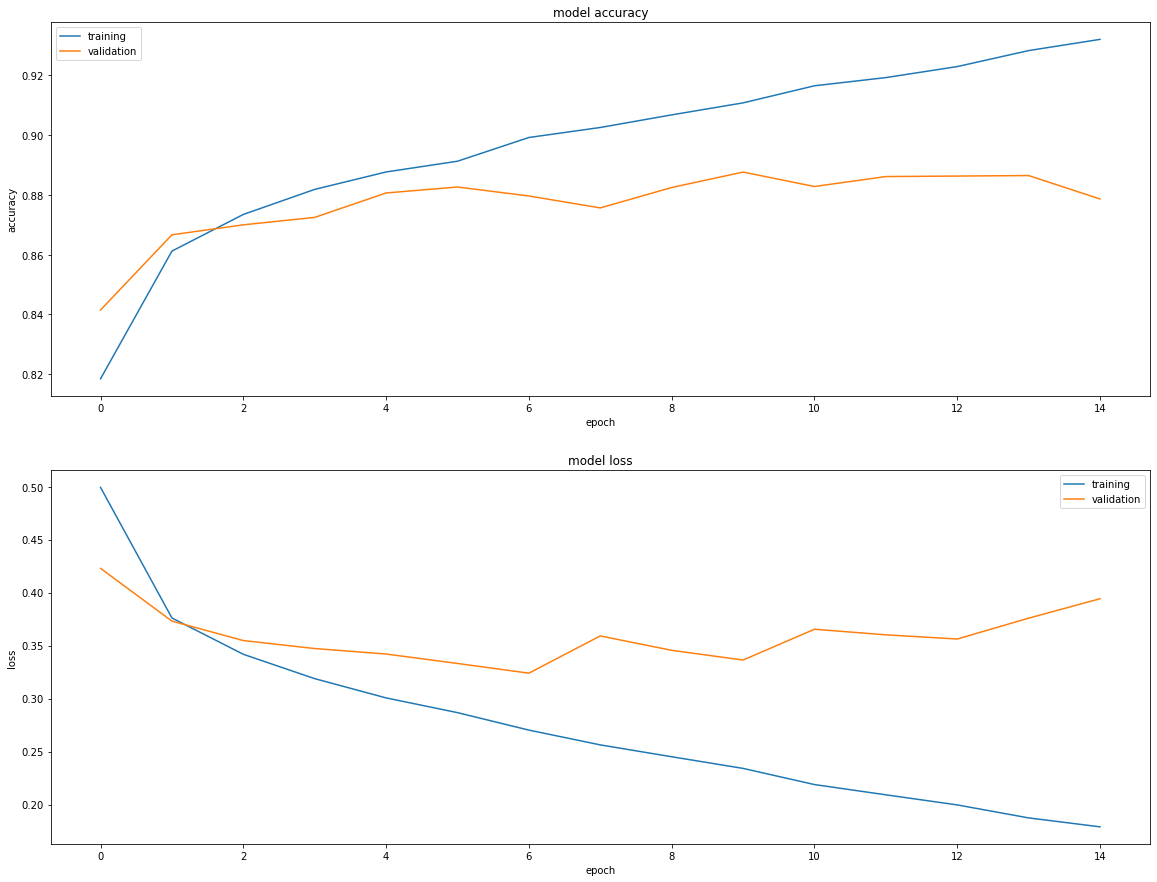

In [46]:
plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history_02.history['accuracy'], history_02.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history_02.history['loss'], history_02.history['val_loss'], 'loss', 212)

In [47]:
history_02_dict = history_02.history
history_02_df=pd.DataFrame(history_02_dict)
history_02_df.tail().round(3)

,loss,accuracy,val_loss,val_accuracy
10,0.219,0.917,0.365,0.883
11,0.209,0.919,0.360,0.886
12,0.200,0.923,0.356,0.886
13,0.187,0.928,0.376,0.887
14,0.179,0.932,0.394,0.879


In [48]:
pred_02 = model_02.predict(x_test_tf)
pred_02_cm=np.argmax(pred_02, axis=1)
print_validation_report(y_test, pred_02_cm)

313/313 [==============================] - 3s 9ms/step
Classification Report
              precision    recall  f1-score   support

           0       0.82      0.82      0.82      1000
           1       0.98      0.97      0.98      1000
           2       0.86      0.77      0.82      1000
           3       0.84      0.86      0.85      1000
           4       0.75      0.84      0.79      1000
           5       0.97      0.94      0.95      1000
           6       0.69      0.67      0.68      1000
           7       0.90      0.98      0.94      1000
           8       0.96      0.96      0.96      1000
           9       0.97      0.93      0.95      1000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000

Accuracy Score: 0.8734
Root Mean Square Error: 1.2881770064707723


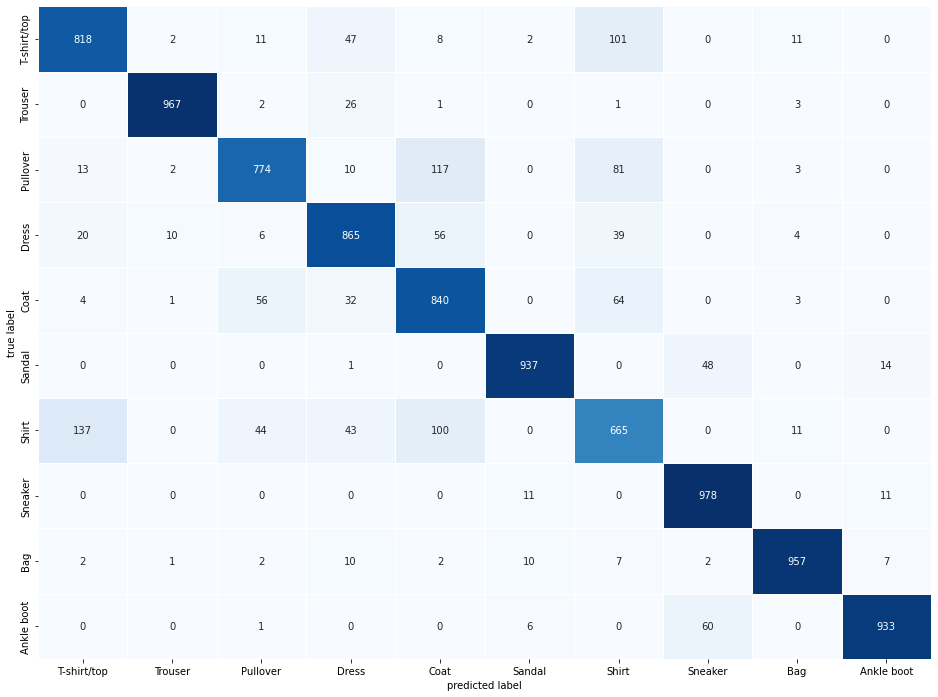

In [49]:
plot_confusion_matrix(y_test,pred_02_cm)

In [50]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)
df = pd.DataFrame(pred_02[0:20], columns = class_names)
df.style.format("{:.2%}").background_gradient(cmap=cm)

,T-shirt/top,Trouser,Pullover,Dress,Coat,Sandal,Shirt,Sneaker,Bag,Ankle boot
0,0.00%,0.00%,0.00%,0.00%,0.00%,0.02%,0.00%,0.25%,0.00%,99.72%
1,0.05%,0.00%,97.00%,0.10%,0.91%,0.00%,1.90%,0.00%,0.03%,0.00%
2,0.00%,100.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
3,0.00%,99.99%,0.00%,0.01%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
4,19.70%,0.01%,18.10%,0.41%,0.72%,0.00%,60.78%,0.01%,0.26%,0.01%
5,0.00%,100.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
6,26.48%,0.15%,6.27%,16.53%,21.59%,0.01%,28.94%,0.01%,0.01%,0.01%
7,0.05%,0.00%,0.11%,0.47%,2.80%,0.00%,96.57%,0.00%,0.00%,0.00%
8,0.00%,0.00%,0.00%,0.00%,0.00%,98.85%,0.00%,0.99%,0.00%,0.16%
9,0.00%,0.00%,0.00%,0.00%,0.00%,0.04%,0.00%,99.48%,0.00%,0.48%


## Experiment 3

- inception_v3
- DNN with 2 layers (384, 768)
- no regularization

In [27]:
k.clear_session()
model_03 = Sequential([
   inception_v3,
   Flatten(),
   Dense(units=384,activation=tf.nn.relu),
#   Dense(units=384,activation=tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
#   BatchNormalization(),
#   Dropout(0.2),
   Dense(units=768,activation=tf.nn.relu),
#   Dense(units=768,activation=tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
#   BatchNormalization(),
#   Dropout(0.2),
   Dense(units=10, activation=tf.nn.softmax)       
])

In [28]:
model_03.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 1, 1, 2048)        21802784  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 384)               786816    
                                                                 
 dense_1 (Dense)             (None, 768)               295680    
                                                                 
 dense_2 (Dense)             (None, 10)                7690      
                                                                 
Total params: 22,892,970
Trainable params: 1,090,186
Non-trainable params: 21,802,784
_________________________________________________________________


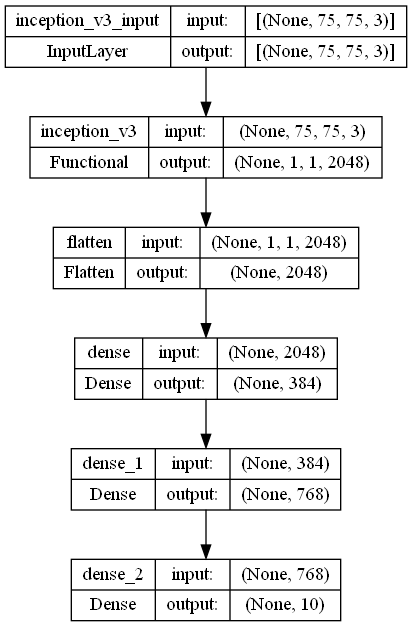

In [29]:
keras.utils.plot_model(model_03, "FASHION-MNIST_PT_EXP-03.png", show_shapes=True) 

In [30]:
model_03.compile(optimizer='adam',
               loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])

In [31]:
history_03 = model_03.fit(x_train_tf_inception
                    ,y_train
                    ,epochs=200
                    ,batch_size=32
                    ,verbose=1
                    ,validation_data=(x_valid_tf_inception, y_valid)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("FASHION-MNIST_PT_EXP-03.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5),
                    ]                                                                                                           
                   )

Epoch 1/200
1688/1688 [==============================] - 53s 27ms/step - loss: 0.5242 - accuracy: 0.8101 - val_loss: 0.4383 - val_accuracy: 0.8390
Epoch 2/200
1688/1688 [==============================] - 45s 27ms/step - loss: 0.3956 - accuracy: 0.8538 - val_loss: 0.4231 - val_accuracy: 0.8417
Epoch 3/200
1688/1688 [==============================] - 42s 25ms/step - loss: 0.3439 - accuracy: 0.8729 - val_loss: 0.4253 - val_accuracy: 0.8505
Epoch 4/200
1688/1688 [==============================] - 42s 25ms/step - loss: 0.3050 - accuracy: 0.8864 - val_loss: 0.4317 - val_accuracy: 0.8507
Epoch 5/200
1688/1688 [==============================] - 42s 25ms/step - loss: 0.2705 - accuracy: 0.8981 - val_loss: 0.4801 - val_accuracy: 0.8462
Epoch 6/200
1688/1688 [==============================] - 43s 25ms/step - loss: 0.2367 - accuracy: 0.9096 - val_loss: 0.4610 - val_accuracy: 0.8628
Epoch 7/200
1688/1688 [==============================] - 43s 25ms/step - loss: 0.2128 - accuracy: 0.9190 - val_loss: 0

In [32]:
model_03 = tf.keras.models.load_model("FASHION-MNIST_PT_EXP-03.h5") # inception_v3, no regularization
print(f"Test acc: {model_03.evaluate(x_test_tf_inception, y_test)[1]:.3f}")

313/313 [==============================] - 8s 22ms/step - loss: 0.4356 - accuracy: 0.8427
Test acc: 0.843


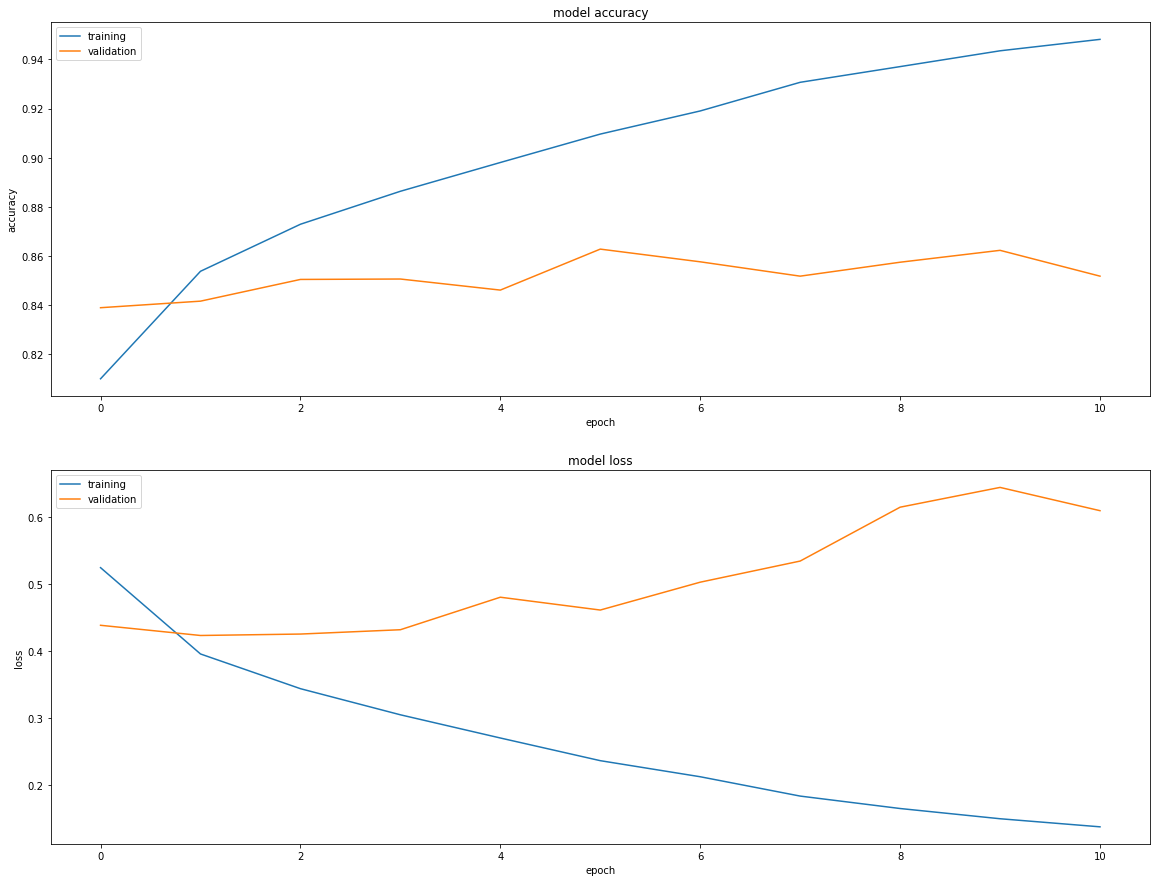

In [33]:
plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history_03.history['accuracy'], history_03.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history_03.history['loss'], history_03.history['val_loss'], 'loss', 212)

In [34]:
history_03_dict = history_03.history
history_03_df=pd.DataFrame(history_03_dict)
history_03_df.tail().round(3)

,loss,accuracy,val_loss,val_accuracy
6,0.213,0.919,0.503,0.858
7,0.184,0.931,0.534,0.852
8,0.165,0.937,0.614,0.858
9,0.150,0.943,0.644,0.862
10,0.138,0.948,0.609,0.852


In [35]:
pred_03 = model_03.predict(x_test_tf_inception)
pred_03_cm=np.argmax(pred_03, axis=1)
print_validation_report(y_test, pred_03_cm)

313/313 [==============================] - 7s 19ms/step
Classification Report
              precision    recall  f1-score   support

           0       0.85      0.74      0.79      1000
           1       0.98      0.96      0.97      1000
           2       0.84      0.76      0.80      1000
           3       0.81      0.78      0.79      1000
           4       0.63      0.86      0.73      1000
           5       0.93      0.94      0.94      1000
           6       0.64      0.56      0.60      1000
           7       0.91      0.93      0.92      1000
           8       0.94      0.96      0.95      1000
           9       0.96      0.92      0.94      1000

    accuracy                           0.84     10000
   macro avg       0.85      0.84      0.84     10000
weighted avg       0.85      0.84      0.84     10000

Accuracy Score: 0.8427
Root Mean Square Error: 1.355728586406586


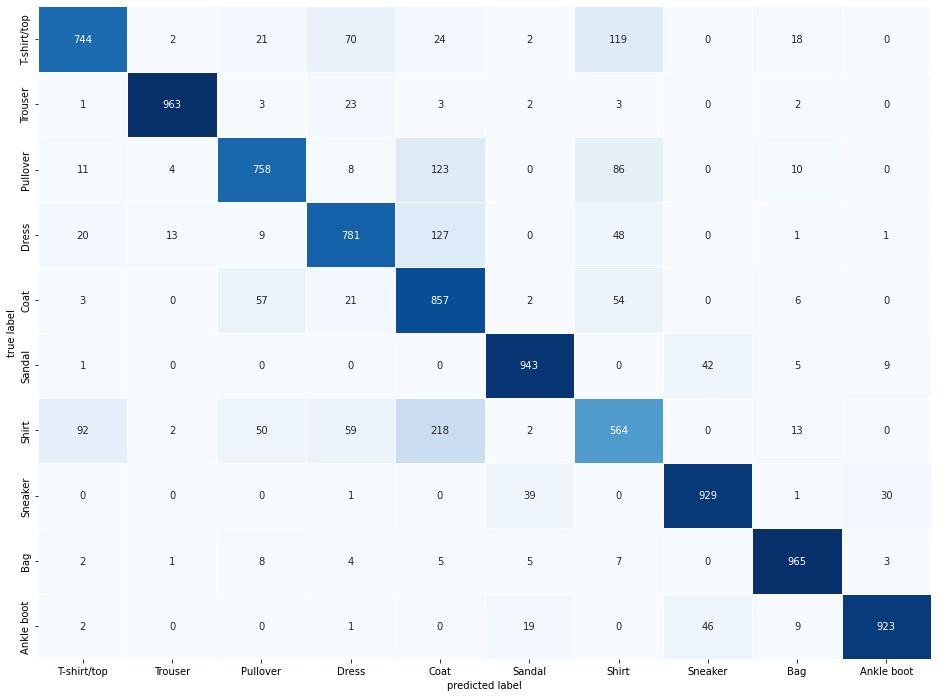

In [36]:
plot_confusion_matrix(y_test,pred_03_cm)

In [37]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)
df = pd.DataFrame(pred_03[0:20], columns = class_names)
df.style.format("{:.2%}").background_gradient(cmap=cm)

,T-shirt/top,Trouser,Pullover,Dress,Coat,Sandal,Shirt,Sneaker,Bag,Ankle boot
0,0.00%,0.00%,0.00%,0.00%,0.00%,0.10%,0.00%,0.28%,0.00%,99.62%
1,0.00%,0.00%,99.81%,0.00%,0.16%,0.00%,0.03%,0.00%,0.00%,0.00%
2,0.00%,99.99%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
3,0.00%,99.99%,0.00%,0.01%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
4,15.79%,0.06%,9.69%,5.22%,5.98%,0.00%,63.14%,0.00%,0.10%,0.00%
5,0.00%,99.89%,0.00%,0.09%,0.01%,0.00%,0.01%,0.00%,0.00%,0.00%
6,4.97%,0.84%,33.71%,8.53%,31.86%,0.08%,19.70%,0.02%,0.25%,0.05%
7,1.09%,0.04%,0.18%,16.43%,1.90%,0.00%,80.35%,0.00%,0.00%,0.00%
8,0.00%,0.00%,0.00%,0.00%,0.00%,99.99%,0.00%,0.01%,0.00%,0.00%
9,0.00%,0.00%,0.00%,0.00%,0.00%,1.10%,0.00%,98.89%,0.00%,0.02%


- Difficulty in using pre-trained models is that it is trained using colored images from imagenet
- B/W images from Fashion-MNIST need to be transformed to meet pre-trained model requirements (3-channel RGB color, resized larger than original 28x28)
- Image quality may suffer in the tgranformation process and make it more difficult for the pre-trained models to classify

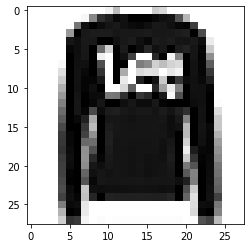

In [38]:
# original B/W image
plt.imshow(x_test[1], cmap=plt.cm.binary)
plt.show()

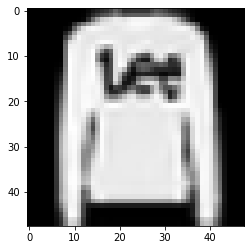

In [45]:
# transformed image: 3-channel RGB, inversed, 48x48 resolution
plt.imshow(x_test_tf[1], cmap=plt.cm.binary)
plt.show()

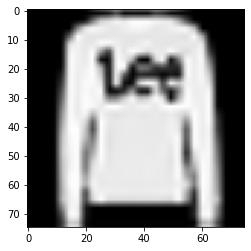

In [46]:
# transformed image: 3-channel RGB, inversed, 75x75 resolution
plt.imshow(x_test_tf_inception[1], cmap=plt.cm.binary)
plt.show()

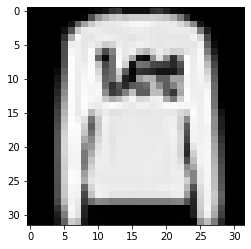

In [47]:
# transformed image: 3-channel RGB, inversed, 75x75 resolution
plt.imshow(x_test_tf_resnet[1], cmap=plt.cm.binary)
plt.show()

## Experiment 4

- ResNet152_v2
- DNN with 2 layers (384, 768)
- no regularization

In [50]:
k.clear_session()
model_04 = Sequential([
   resnet152_V2,
#   vgg_19,
   Flatten(),
   Dense(units=384,activation=tf.nn.relu),
#   Dense(units=384,activation=tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
#   BatchNormalization(),
#   Dropout(0.2),
   Dense(units=768,activation=tf.nn.relu),
#   Dense(units=768,activation=tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
#   BatchNormalization(),
#   Dropout(0.2),
   Dense(units=10, activation=tf.nn.softmax)       
])

In [51]:
model_04.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152v2 (Functional)    (None, 1, 1, 2048)        58331648  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 384)               786816    
                                                                 
 dense_1 (Dense)             (None, 768)               295680    
                                                                 
 dense_2 (Dense)             (None, 10)                7690      
                                                                 
Total params: 59,421,834
Trainable params: 1,090,186
Non-trainable params: 58,331,648
_________________________________________________________________


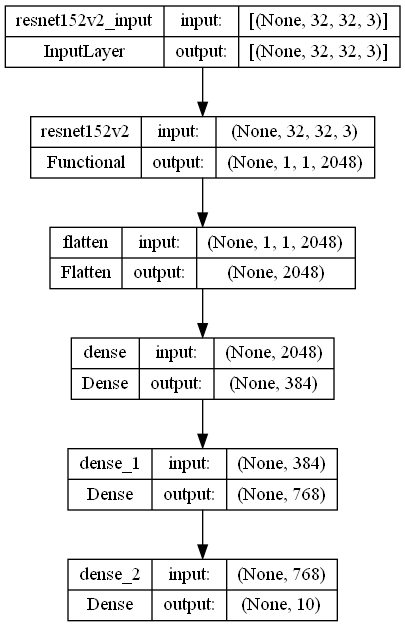

In [52]:
keras.utils.plot_model(model_04, "FASHION-MNIST_PT_EXP-04.png", show_shapes=True) 

In [53]:
model_04.compile(optimizer='adam',
               loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])

In [54]:
history_04 = model_04.fit(x_train_tf_resnet
                    ,y_train
                    ,epochs=200
                    ,batch_size=64
                    ,verbose=1
                    ,validation_data=(x_valid_tf_resnet, y_valid)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("FASHION-MNIST_PT_EXP-04.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5),
                    ]                                                                                                           
                   )

Epoch 1/200
844/844 [==============================] - 50s 49ms/step - loss: 0.7266 - accuracy: 0.7410 - val_loss: 0.6006 - val_accuracy: 0.7738
Epoch 2/200
844/844 [==============================] - 40s 47ms/step - loss: 0.5528 - accuracy: 0.7945 - val_loss: 0.5887 - val_accuracy: 0.7840
Epoch 3/200
844/844 [==============================] - 41s 48ms/step - loss: 0.4927 - accuracy: 0.8157 - val_loss: 0.5472 - val_accuracy: 0.7993
Epoch 4/200
844/844 [==============================] - 37s 44ms/step - loss: 0.4488 - accuracy: 0.8301 - val_loss: 0.5485 - val_accuracy: 0.7963
Epoch 5/200
844/844 [==============================] - 37s 44ms/step - loss: 0.4106 - accuracy: 0.8440 - val_loss: 0.5695 - val_accuracy: 0.8008
Epoch 6/200
844/844 [==============================] - 37s 44ms/step - loss: 0.3759 - accuracy: 0.8580 - val_loss: 0.5818 - val_accuracy: 0.8002
Epoch 7/200
844/844 [==============================] - 37s 44ms/step - loss: 0.3451 - accuracy: 0.8690 - val_loss: 0.5985 - val_ac

In [55]:
model_04 = tf.keras.models.load_model("FASHION-MNIST_PT_EXP-04.h5") # VGG16, no regularization
print(f"Test acc: {model_04.evaluate(x_test_tf_resnet, y_test)[1]:.3f}")

313/313 [==============================] - 15s 39ms/step - loss: 0.5640 - accuracy: 0.7925
Test acc: 0.793


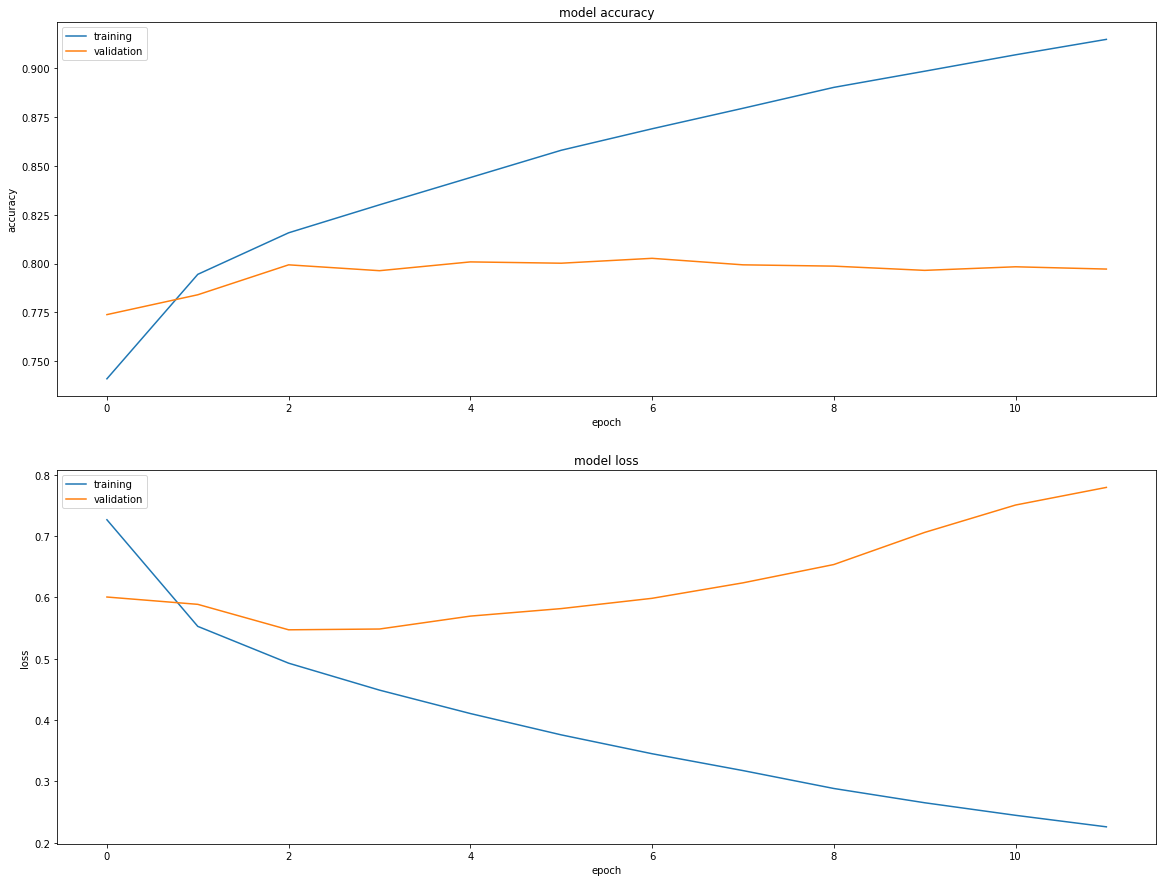

In [56]:
plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history_04.history['accuracy'], history_04.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history_04.history['loss'], history_04.history['val_loss'], 'loss', 212)

In [57]:
history_04_dict = history_04.history
history_04_df=pd.DataFrame(history_04_dict)
history_04_df.tail().round(3)

,loss,accuracy,val_loss,val_accuracy
7,0.318,0.880,0.624,0.799
8,0.288,0.890,0.654,0.799
9,0.265,0.899,0.706,0.797
10,0.245,0.907,0.751,0.798
11,0.226,0.915,0.779,0.797


In [58]:
pred_04 = model_04.predict(x_test_tf_resnet)
pred_04_cm=np.argmax(pred_04, axis=1)
print_validation_report(y_test, pred_04_cm)

313/313 [==============================] - 13s 35ms/step
Classification Report
              precision    recall  f1-score   support

           0       0.71      0.77      0.74      1000
           1       0.96      0.92      0.94      1000
           2       0.74      0.60      0.67      1000
           3       0.76      0.77      0.76      1000
           4       0.63      0.68      0.65      1000
           5       0.94      0.90      0.92      1000
           6       0.51      0.52      0.51      1000
           7       0.87      0.94      0.90      1000
           8       0.87      0.91      0.89      1000
           9       0.96      0.91      0.93      1000

    accuracy                           0.79     10000
   macro avg       0.79      0.79      0.79     10000
weighted avg       0.79      0.79      0.79     10000

Accuracy Score: 0.7925
Root Mean Square Error: 1.6156113394006617


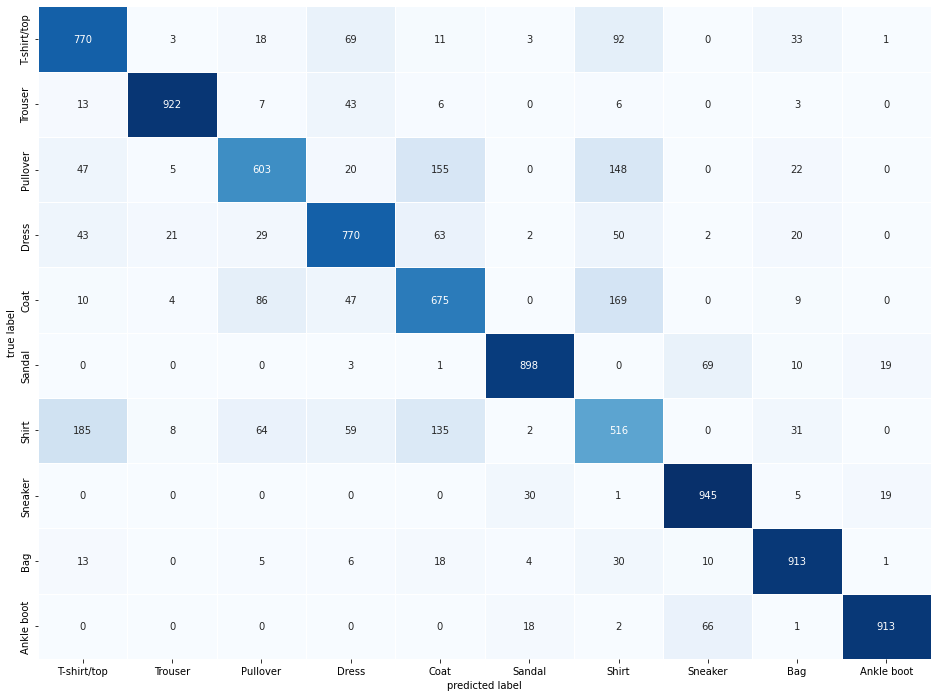

In [59]:
plot_confusion_matrix(y_test,pred_04_cm)

In [60]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)
df = pd.DataFrame(pred_04[0:20], columns = class_names)
df.style.format("{:.2%}").background_gradient(cmap=cm)

,T-shirt/top,Trouser,Pullover,Dress,Coat,Sandal,Shirt,Sneaker,Bag,Ankle boot
0,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.06%,0.00%,99.93%
1,5.88%,0.80%,85.07%,2.99%,2.70%,0.02%,1.87%,0.01%,0.66%,0.00%
2,0.00%,100.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
3,0.14%,99.63%,0.01%,0.13%,0.01%,0.00%,0.08%,0.00%,0.00%,0.00%
4,60.31%,0.07%,5.51%,8.57%,2.72%,0.07%,18.60%,0.00%,4.14%,0.01%
5,0.00%,100.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
6,5.93%,0.38%,0.66%,84.68%,2.07%,0.01%,6.24%,0.00%,0.04%,0.00%
7,17.53%,1.18%,3.76%,17.23%,22.30%,0.01%,37.85%,0.00%,0.15%,0.01%
8,0.00%,0.00%,0.00%,0.00%,0.00%,99.85%,0.00%,0.14%,0.01%,0.00%
9,0.00%,0.00%,0.00%,0.00%,0.00%,0.60%,0.00%,99.35%,0.00%,0.04%


## Experiment 5

- VGG16
- DNN with 2 layers (384, 768)
- Batch Normalization
- Dropout(0.2)
- L2 Regularization(0.001) 

In [64]:
k.clear_session()
model_05 = Sequential([
   vgg_16,
   Flatten(),
   Dense(units=384,activation=tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
   BatchNormalization(),
   Dropout(0.2),
   Dense(units=768,activation=tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
   BatchNormalization(),
   Dropout(0.2),
   Dense(units=10, activation=tf.nn.softmax)       
])

In [65]:
model_05.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 384)               196992    
                                                                 
 batch_normalization (BatchN  (None, 384)              1536      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 384)               0         
                                                                 
 dense_1 (Dense)             (None, 768)               295680    
                                                        

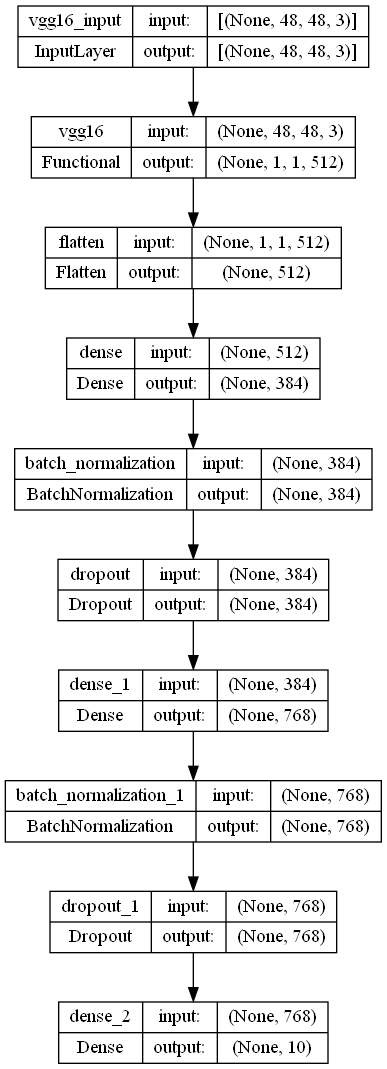

In [66]:
keras.utils.plot_model(model_05, "FASHION-MNIST_PT_EXP-05.png", show_shapes=True) 

In [67]:
model_05.compile(optimizer='adam',
               loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])

In [68]:
history_05 = model_05.fit(x_train_tf
                    ,y_train
                    ,epochs=200
                    ,batch_size=64
                    ,verbose=1
                    ,validation_data=(x_valid_tf, y_valid)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("FASHION-MNIST_PT_EXP-05.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5),
                    ]                                                                                                           
                   )

Epoch 1/200
844/844 [==============================] - 17s 18ms/step - loss: 1.0677 - accuracy: 0.8167 - val_loss: 0.7524 - val_accuracy: 0.8555
Epoch 2/200
844/844 [==============================] - 15s 18ms/step - loss: 0.6910 - accuracy: 0.8501 - val_loss: 0.5769 - val_accuracy: 0.8617
Epoch 3/200
844/844 [==============================] - 15s 18ms/step - loss: 0.5784 - accuracy: 0.8523 - val_loss: 0.5725 - val_accuracy: 0.8505
Epoch 4/200
844/844 [==============================] - 15s 18ms/step - loss: 0.5400 - accuracy: 0.8542 - val_loss: 0.5080 - val_accuracy: 0.8657
Epoch 5/200
844/844 [==============================] - 15s 18ms/step - loss: 0.5207 - accuracy: 0.8572 - val_loss: 0.4871 - val_accuracy: 0.8658
Epoch 6/200
844/844 [==============================] - 15s 17ms/step - loss: 0.5112 - accuracy: 0.8563 - val_loss: 0.5291 - val_accuracy: 0.8465
Epoch 7/200
844/844 [==============================] - 15s 18ms/step - loss: 0.5010 - accuracy: 0.8588 - val_loss: 0.4813 - val_ac

In [69]:
model_05 = tf.keras.models.load_model("FASHION-MNIST_PT_EXP-05.h5") # VGG16, regularization
print(f"Test acc: {model_05.evaluate(x_test_tf, y_test)[1]:.3f}")

313/313 [==============================] - 4s 10ms/step - loss: 0.4990 - accuracy: 0.8541
Test acc: 0.854


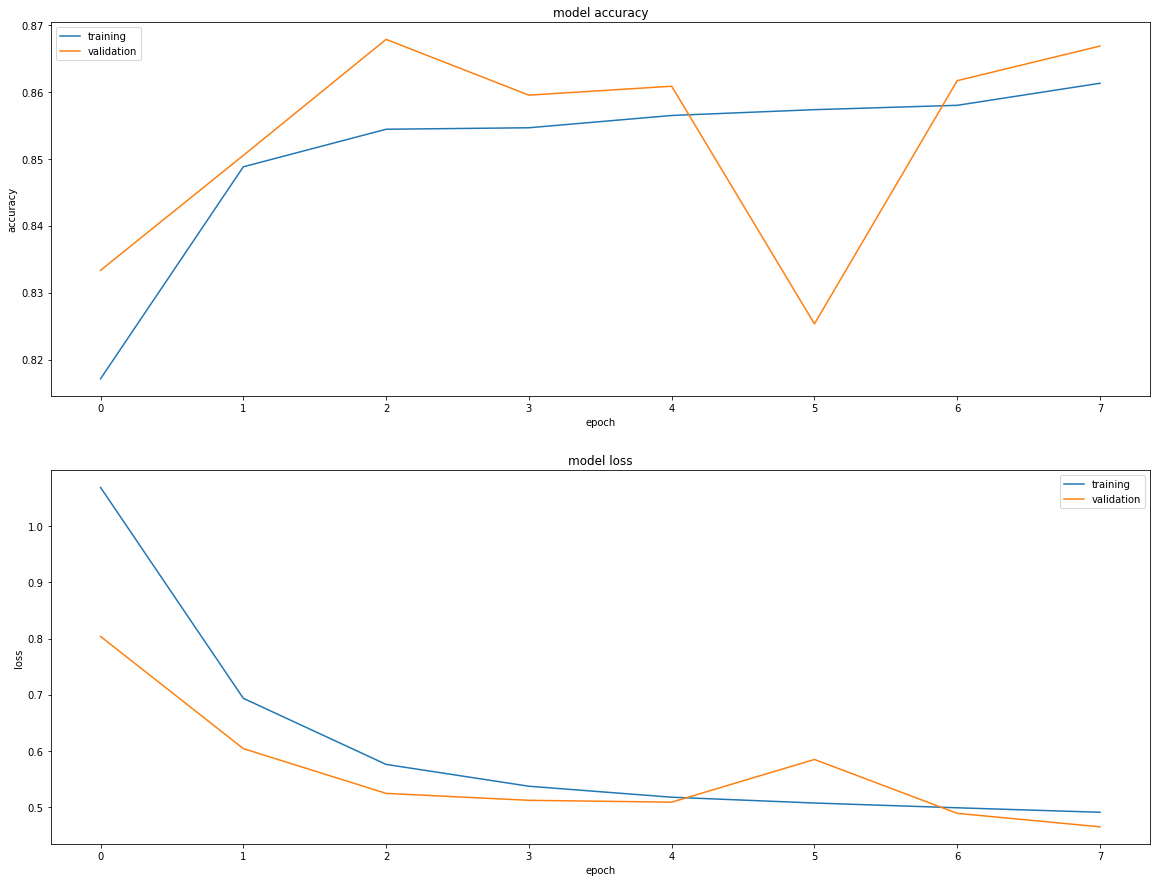

In [71]:
plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history_05.history['accuracy'], history_05.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history_05.history['loss'], history_05.history['val_loss'], 'loss', 212)

In [72]:
history_05_dict = history_05.history
history_05_df=pd.DataFrame(history_05_dict)
history_05_df.tail().round(3)

,loss,accuracy,val_loss,val_accuracy
3,0.537,0.855,0.512,0.859
4,0.517,0.856,0.508,0.861
5,0.507,0.857,0.584,0.825
6,0.498,0.858,0.488,0.862
7,0.490,0.861,0.464,0.867


In [73]:
pred_05 = model_05.predict(x_test_tf)
pred_05_cm=np.argmax(pred_05, axis=1)
print_validation_report(y_test, pred_05_cm)

313/313 [==============================] - 3s 8ms/step
Classification Report
              precision    recall  f1-score   support

           0       0.78      0.88      0.83      1000
           1       0.99      0.96      0.98      1000
           2       0.83      0.74      0.78      1000
           3       0.82      0.87      0.84      1000
           4       0.67      0.86      0.76      1000
           5       0.94      0.96      0.95      1000
           6       0.76      0.51      0.61      1000
           7       0.93      0.94      0.94      1000
           8       0.97      0.96      0.97      1000
           9       0.96      0.94      0.95      1000

    accuracy                           0.86     10000
   macro avg       0.87      0.86      0.86     10000
weighted avg       0.87      0.86      0.86     10000

Accuracy Score: 0.8633
Root Mean Square Error: 1.2683847996566342


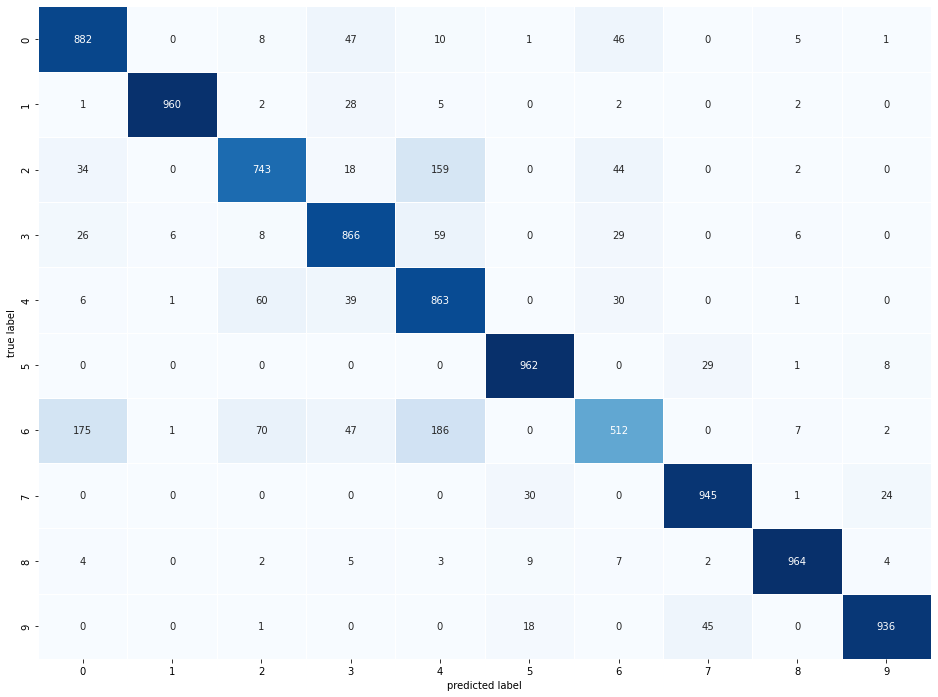

In [74]:
plot_confusion_matrix(y_test,pred_05_cm)

In [75]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)
df = pd.DataFrame(pred_05[0:20], columns = class_names)
df.style.format("{:.2%}").background_gradient(cmap=cm)

,T-shirt/top,Trouser,Pullover,Dress,Coat,Sandal,Shirt,Sneaker,Bag,Ankle boot
0,0.00%,0.00%,0.00%,0.00%,0.00%,0.03%,0.00%,0.20%,0.00%,99.77%
1,0.43%,0.00%,99.38%,0.06%,0.04%,0.00%,0.09%,0.00%,0.00%,0.00%
2,0.00%,100.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
3,0.00%,99.98%,0.00%,0.02%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
4,33.71%,0.01%,2.07%,3.74%,9.14%,0.06%,51.26%,0.01%,0.02%,0.00%
5,0.00%,99.98%,0.00%,0.01%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
6,11.84%,0.02%,1.78%,7.05%,32.52%,0.00%,46.78%,0.01%,0.00%,0.00%
7,0.04%,0.01%,1.10%,2.61%,1.99%,0.02%,94.20%,0.03%,0.00%,0.00%
8,0.00%,0.00%,0.00%,0.00%,0.00%,97.81%,0.00%,2.18%,0.00%,0.01%
9,0.00%,0.00%,0.00%,0.00%,0.00%,3.84%,0.00%,96.16%,0.00%,0.01%


- VGG16 w/DNN regularization: worse accuracy than with no regularization
- next: tinker with L2 Regularization - same settings as Conv2d Exp 6 

## Experiment 6

- VGG16
- DNN with 2 layers (384, 768)
- Batch Normalization
- Dropout(0.2)
- L2 Regularization(0.01) 
- DNN based on Conv2D Exp 6 regularization hyperparamters

In [26]:
k.clear_session()
model_06 = Sequential([
   vgg_16,
   Flatten(),
   Dense(units=384,activation=tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.01)),
   BatchNormalization(),
   Dropout(0.2),
   Dense(units=768,activation=tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.01)),
   BatchNormalization(),
   Dropout(0.2),
   Dense(units=10, activation=tf.nn.softmax)       
])

In [27]:
model_06.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 384)               196992    
                                                                 
 batch_normalization (BatchN  (None, 384)              1536      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 384)               0         
                                                                 
 dense_1 (Dense)             (None, 768)               295680    
                                                        

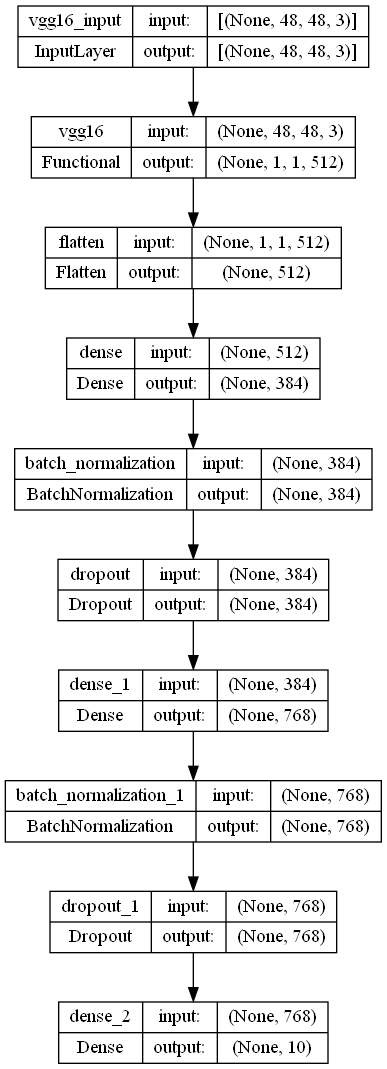

In [28]:
keras.utils.plot_model(model_06, "FASHION-MNIST_PT_EXP-06.png", show_shapes=True) 

In [29]:
model_06.compile(optimizer='adam',
               loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])

In [30]:
history_06 = model_06.fit(x_train_tf
                    ,y_train
                    ,epochs=200
                    ,batch_size=64
                    ,verbose=1
                    ,validation_data=(x_valid_tf, y_valid)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("FASHION-MNIST_PT_EXP-06.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5),
                    ]                                                                                                           
                   )

Epoch 1/200
844/844 [==============================] - 20s 18ms/step - loss: 2.2541 - accuracy: 0.8018 - val_loss: 1.0171 - val_accuracy: 0.7423
Epoch 2/200
844/844 [==============================] - 15s 18ms/step - loss: 0.7465 - accuracy: 0.8236 - val_loss: 0.7735 - val_accuracy: 0.7987
Epoch 3/200
844/844 [==============================] - 15s 18ms/step - loss: 0.6822 - accuracy: 0.8260 - val_loss: 0.7187 - val_accuracy: 0.8108
Epoch 4/200
844/844 [==============================] - 15s 18ms/step - loss: 0.6560 - accuracy: 0.8270 - val_loss: 0.6349 - val_accuracy: 0.8287
Epoch 5/200
844/844 [==============================] - 15s 18ms/step - loss: 0.6153 - accuracy: 0.8314 - val_loss: 0.6137 - val_accuracy: 0.8228
Epoch 6/200
844/844 [==============================] - 15s 18ms/step - loss: 0.5945 - accuracy: 0.8351 - val_loss: 0.7386 - val_accuracy: 0.7777
Epoch 7/200
844/844 [==============================] - 15s 18ms/step - loss: 0.5800 - accuracy: 0.8357 - val_loss: 0.6095 - val_ac

In [31]:
model_06 = tf.keras.models.load_model("FASHION-MNIST_PT_EXP-06.h5") # VGG16, regularization
print(f"Test acc: {model_06.evaluate(x_test_tf, y_test)[1]:.3f}")

313/313 [==============================] - 4s 10ms/step - loss: 0.5479 - accuracy: 0.8332
Test acc: 0.833


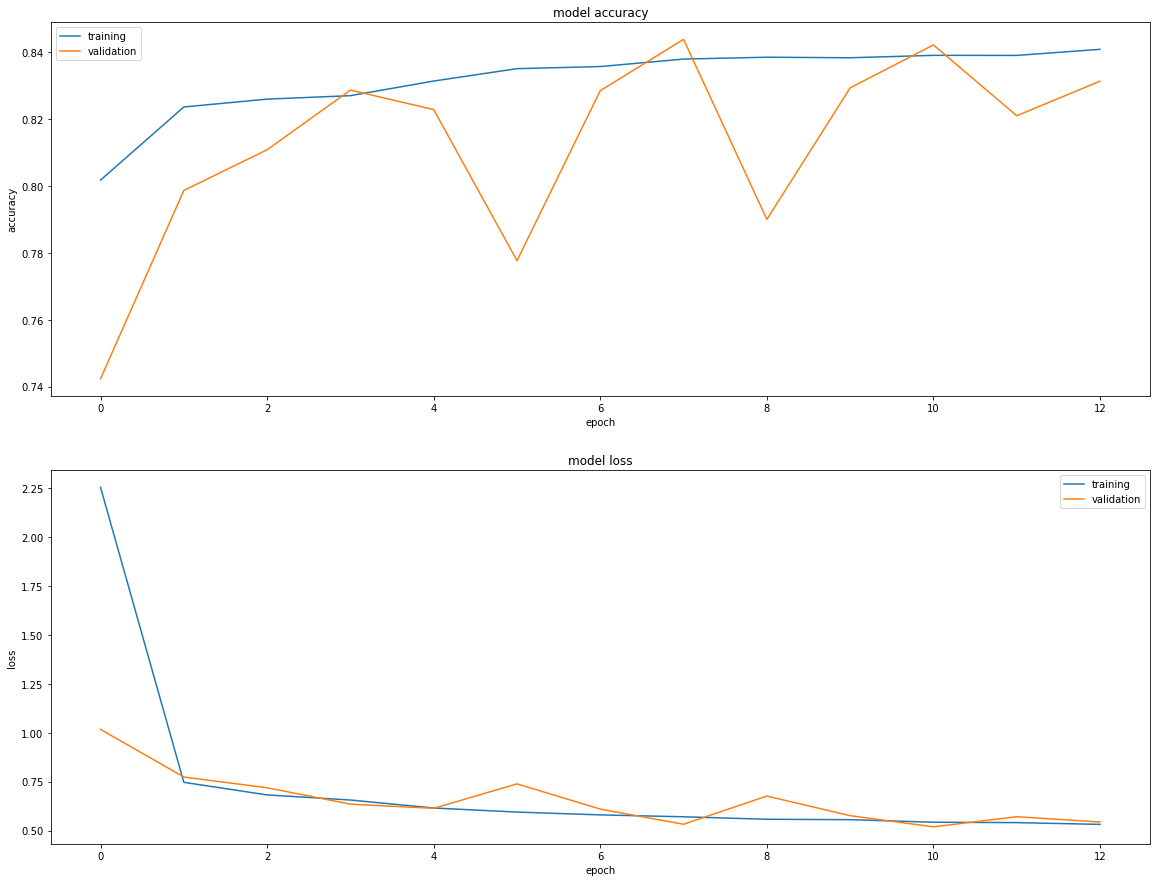

In [32]:
plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history_06.history['accuracy'], history_06.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history_06.history['loss'], history_06.history['val_loss'], 'loss', 212)

In [33]:
history_06_dict = history_06.history
history_06_df=pd.DataFrame(history_06_dict)
history_06_df.tail().round(3)

,loss,accuracy,val_loss,val_accuracy
8,0.558,0.839,0.676,0.790
9,0.556,0.838,0.576,0.829
10,0.543,0.839,0.519,0.842
11,0.541,0.839,0.571,0.821
12,0.532,0.841,0.544,0.831


In [34]:
pred_06 = model_06.predict(x_test_tf)
pred_06_cm=np.argmax(pred_06, axis=1)
print_validation_report(y_test, pred_06_cm)

313/313 [==============================] - 3s 8ms/step
Classification Report
              precision    recall  f1-score   support

           0       0.83      0.75      0.79      1000
           1       0.99      0.97      0.98      1000
           2       0.68      0.85      0.76      1000
           3       0.81      0.85      0.83      1000
           4       0.80      0.55      0.65      1000
           5       0.95      0.92      0.94      1000
           6       0.59      0.62      0.61      1000
           7       0.95      0.86      0.90      1000
           8       0.92      0.97      0.95      1000
           9       0.87      0.98      0.92      1000

    accuracy                           0.83     10000
   macro avg       0.84      0.83      0.83     10000
weighted avg       0.84      0.83      0.83     10000

Accuracy Score: 0.8332
Root Mean Square Error: 1.4721073330433485


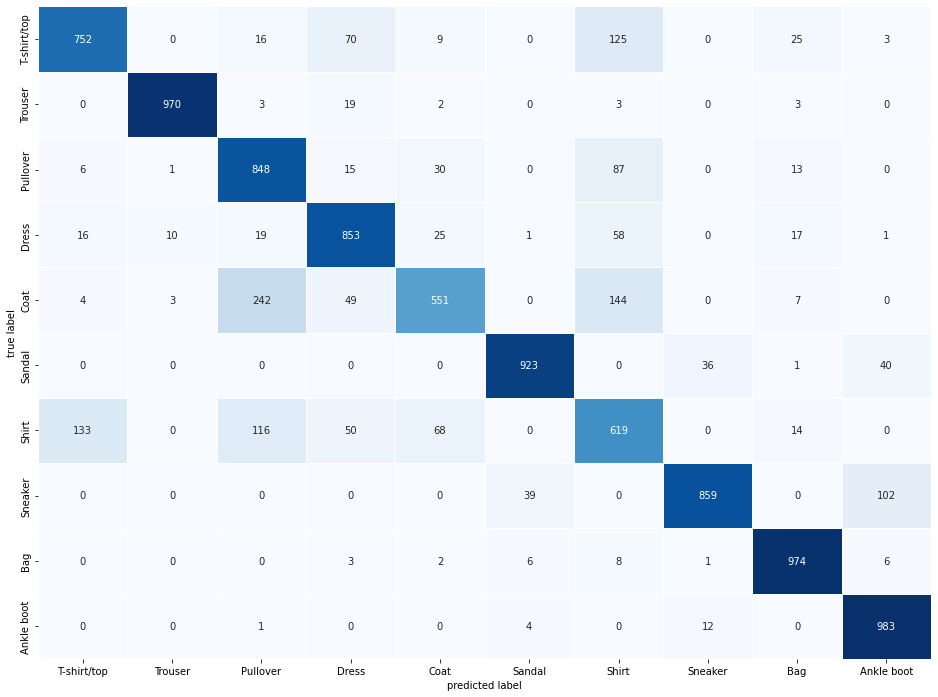

In [35]:
plot_confusion_matrix(y_test,pred_06_cm)

In [36]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)
df = pd.DataFrame(pred_06[0:20], columns = class_names)
df.style.format("{:.2%}").background_gradient(cmap=cm)

,T-shirt/top,Trouser,Pullover,Dress,Coat,Sandal,Shirt,Sneaker,Bag,Ankle boot
0,0.00%,0.00%,0.00%,0.00%,0.00%,0.07%,0.00%,0.20%,0.00%,99.73%
1,0.23%,0.00%,98.81%,0.11%,0.03%,0.00%,0.77%,0.00%,0.05%,0.00%
2,0.00%,99.99%,0.00%,0.01%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
3,0.00%,99.98%,0.00%,0.02%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
4,1.67%,0.06%,6.51%,1.99%,10.81%,0.02%,78.86%,0.00%,0.05%,0.04%
5,0.00%,100.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
6,1.56%,0.05%,15.37%,3.91%,11.69%,0.00%,67.38%,0.00%,0.01%,0.03%
7,0.62%,0.12%,3.78%,4.23%,8.43%,0.02%,82.29%,0.00%,0.48%,0.02%
8,0.18%,0.01%,0.02%,0.19%,0.01%,96.82%,0.06%,1.56%,0.16%,1.00%
9,0.00%,0.00%,0.00%,0.00%,0.00%,4.34%,0.00%,95.30%,0.00%,0.34%


- Exp 5 VGG16 w/regularization accuracy 0.8380, not as good as Exp 1 VGG w/o regularization
- Worse accuracy compared to Exp 4 using L2 regularization 0.01
- Best pre-trained model: do not use regularization in DNN
- Best overall: Conv@d Exp 6, performs better than pre-trained models
- might be due to using original images, not resized and transformed into 3-channel RGB to meet pre-trained model requirements (becomes blurrier, low-res)

In [ ]:
# original B/W image
plt.imshow(x_test[1], cmap=plt.cm.binary)
plt.show()

In [ ]:
y_test[1]